<h1>A. Data Collection & Exploration

<h2>Import libraries

In [1]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
%matplotlib inline
import sklearn
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder
from pylift import TransformedOutcome
from pylift.generate_data import dgp
from pylift.eval import UpliftEval
from sklearn.cluster import KMeans
from statistics import mean
import sklearn.metrics

<h2>Import dataset

In [2]:
df_data = pd.read_csv('turnover.csv', encoding = "ISO-8859-1")
df_data.index.name = "id"
df_model = df_data.copy()

<h2>Define Cols

In [3]:
#choose the single dependent variable (Positive Outcome)
treat = 'coach'

In [4]:
#choose the treatment variable
target = "event"

In [5]:
#choose a column with hiearchy to be label encoded
label_cols=[treat]

In [6]:
#choose a column with wide range to be clusterred
cluster_cols = ['stag']

<h2>Check uniques for categorical data

In [7]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype == "object"]
for obj in object_cols:
    print('\n', obj)
    for unique in df_data[obj].unique():
        print("{} {}".format(unique,sum(df_data[obj] == unique)))


 gender
m 276
f 853

 industry
Banks 114
PowerGeneration 38
Retail 289
manufacture 145
Consult 74
State 55
etc 94
Building 41
IT 122
 HoReCa 11
Telecom 36
Pharma 20
Mining 24
transport 38
Agriculture 15
RealEstate 13

 profession
HR 757
Commercial 23
Marketing 31
etc 37
Sales 66
BusinessDevelopment 27
Finanñe 17
Teaching 12
manage 22
IT 74
Law 7
Consult 25
Engineer 15
PR 6
Accounting 10

 traffic
rabrecNErab 211
empjs 248
youjs 318
referal 95
advert 33
KA 67
recNErab 39
friends 118

 coach
no 683
yes 132
my head 314

 head_gender
f 545
m 584

 greywage
white 1002
grey 127

 way
bus 681
car 331
foot 117


<h1>B. Data Preprocessing

<h2>Label encoding hierarchy columns

In [8]:
#Label encoding
print("label encoding columns:",label_cols)
label_encoder = LabelEncoder()
for col in label_cols:
    df_model[col] = label_encoder.fit_transform(df_data[col])
    df_model[col] = label_encoder.transform(df_data[col])
print(">>label encoding finished")

label encoding columns: ['coach']
>>label encoding finished


<h2>Data cleaning

In [9]:
#remove unused columns
###
#remove unused rows
df_model = df_model.loc[df_model[treat] <=1]
#rename target column to 'Stay'
df_model = df_model.rename(columns={target: "Stay"})
df_data = df_data.rename(columns={target: "Stay"})

<h2>Cluster & One Hot Encoding

In [10]:
#function to order clusters
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [11]:
[col for col in df_model.columns if df_model[col].dtype == "float64"]

['stag',
 'age',
 'extraversion',
 'independ',
 'selfcontrol',
 'anxiety',
 'novator']

In [12]:
#preparing float columns to cluster
print('Clustering columns:',cluster_cols)
#creating the clusters
for col in cluster_cols:
    col_cluster = col + "_cluster"
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(df_model[[col]])
    df_model[col_cluster] = kmeans.predict(df_model[[col]])
    #order the clusters
    df_model = order_cluster(col_cluster, col, df_model, True)
print('>>Cluster succeeded!')
#dropping columns that have been clustered
df_model = df_model.drop(cluster_cols,axis=1)

#one hot encoding the rest columns
dummies = pd.get_dummies(df_model)
print("\nOne Hot Encoding:",dummies.columns.values)
df_model = dummies
print('>>One Hot Encoding succeeded!')

Clustering columns: ['stag']
>>Cluster succeeded!

One Hot Encoding: ['Stay' 'age' 'coach' 'extraversion' 'independ' 'selfcontrol' 'anxiety'
 'novator' 'stag_cluster' 'gender_f' 'gender_m' 'industry_ HoReCa'
 'industry_Agriculture' 'industry_Banks' 'industry_Building'
 'industry_Consult' 'industry_IT' 'industry_Mining' 'industry_Pharma'
 'industry_PowerGeneration' 'industry_RealEstate' 'industry_Retail'
 'industry_State' 'industry_Telecom' 'industry_etc' 'industry_manufacture'
 'industry_transport' 'profession_Accounting'
 'profession_BusinessDevelopment' 'profession_Commercial'
 'profession_Consult' 'profession_Engineer' 'profession_Finanñe'
 'profession_HR' 'profession_IT' 'profession_Law' 'profession_Marketing'
 'profession_PR' 'profession_Sales' 'profession_Teaching' 'profession_etc'
 'profession_manage' 'traffic_KA' 'traffic_advert' 'traffic_empjs'
 'traffic_friends' 'traffic_rabrecNErab' 'traffic_recNErab'
 'traffic_referal' 'traffic_youjs' 'head_gender_f' 'head_gender_m'
 'greyw

In [13]:
df_model

,Stay,age,coach,extraversion,independ,selfcontrol,anxiety,novator,stag_cluster,gender_f,...,traffic_recNErab,traffic_referal,traffic_youjs,head_gender_f,head_gender_m,greywage_grey,greywage_white,way_bus,way_car,way_foot
0,1,35.0,1,6.2,4.1,5.7,7.1,8.3,0,0,...,0,0,0,1,0,0,1,1,0,0
1,1,35.0,1,6.2,6.2,2.6,4.8,8.3,0,1,...,0,0,0,0,1,0,1,1,0,0
2,1,35.0,1,5.4,7.6,4.9,2.5,6.7,0,1,...,0,0,0,0,1,0,1,1,0,0
3,1,29.0,1,8.6,6.9,2.6,4.0,7.5,0,1,...,0,0,0,1,0,0,1,1,0,0
4,1,28.0,1,8.6,5.5,4.9,4.8,5.2,0,1,...,0,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,1,22.0,1,7.0,4.8,4.9,6.3,7.5,3,1,...,1,0,0,0,1,0,1,1,0,0
993,0,33.0,0,4.6,3.4,6.4,6.3,6.7,3,1,...,0,0,0,0,1,0,1,0,0,1
994,0,34.0,1,3.8,5.5,6.4,4.0,4.4,3,0,...,0,1,0,0,1,0,1,1,0,0
995,1,24.0,1,3.8,6.2,8.0,4.0,2.9,3,0,...,0,1,0,0,1,0,1,1,0,0


<h2>Categorizing target class

Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)
>>Categorizing successfull!


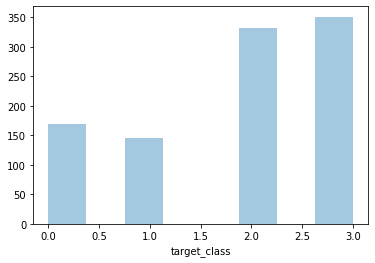

In [14]:
print("Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)")
#to get the CN employees we can simply set the basic value of all data in column target_class equal to 0 
df_model['target_class'] = 0 #CN

#after that we set CR employees with target_class equal to 1 
df_model.loc[(df_model[treat] == 0) & (df_model.Stay > 0),'target_class'] = 1 #CR

#after that we set TN employees with with target_class equal to 2
df_model.loc[(df_model[treat] == 1) & (df_model.Stay == 0),'target_class'] = 2 #TN

#after that we set TR employees with with target_class equal to 3
df_model.loc[(df_model[treat] == 1) & (df_model.Stay > 0),'target_class'] = 3 #TR

print(">>Categorizing successfull!")
sns.distplot(a=df_model.target_class, kde=False)

<h2>Explore data Correlation

In [15]:
#measure the correlation of Employee who stay
pd.options.display.max_rows=100
correlation = df_model.corr(method ='pearson') 
correlation.Stay.sort_values() * 100

industry_IT                       -15.332231
way_foot                          -10.985712
traffic_friends                   -10.708335
profession_HR                     -10.350486
profession_IT                      -7.587150
traffic_youjs                      -7.114859
anxiety                            -6.170444
head_gender_f                      -5.554376
traffic_advert                     -5.284890
greywage_white                     -5.151846
age                                -4.249335
industry_Retail                    -3.591349
industry_Telecom                   -3.434424
industry_PowerGeneration           -3.128780
selfcontrol                        -2.852561
industry_RealEstate                -2.594869
industry_manufacture               -2.421868
gender_m                           -1.788994
stag_cluster                       -1.786458
novator                            -1.621197
industry_transport                 -1.589231
traffic_recNErab                   -0.488037
extraversi

<h2>Create new dataframe for churn and uplift

In [16]:
#duplicate result to df_data for calculating MP & MPU
df_data_churn = df_model[['target_class','Stay',treat]]
print(df_data_churn.head())
# df_data_lift = df_model.copy()
df_data_uplift = df_model[['target_class','Stay',treat]]
print(df_data_uplift.head())

   target_class  Stay  coach
0             3     1      1
1             3     1      1
2             3     1      1
3             3     1      1
4             3     1      1
   target_class  Stay  coach
0             3     1      1
1             3     1      1
2             3     1      1
3             3     1      1
4             3     1      1


<h2>Predicting Target Class(Churn Uplift)

In [17]:
#create feature set and labels
X = df_model.drop(['target_class',treat,'Stay'],axis=1)
y = df_model.target_class
#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict = xgb_model.predict(df_model.drop(['target_class',treat,'Stay'],axis=1))
overall_proba=xgb_model.predict_proba(df_model.drop(['target_class',treat,'Stay'],axis=1))
# insert predicted target to uplift dataframe
df_data_uplift['p_target'] = overall_predict
df_model['p_target'] = overall_predict
# assign probabilities to 4 different columns
df_data_uplift['proba_CN'] = overall_proba[:,0] 
df_data_uplift['proba_CR'] = overall_proba[:,1] 
df_data_uplift['proba_TN'] = overall_proba[:,2] 
df_data_uplift['proba_TR'] = overall_proba[:,3]
#calculate uplift score for all customers
df_data_uplift['uplift_score'] = df_data_uplift.eval('proba_CN/(proba_CN+proba_CR) + proba_TR/(proba_TN+proba_TR) - proba_TN/(proba_TN+proba_TR) - proba_CR/(proba_CN+proba_CR)')
#assign it back to main dataframe
df_data_uplift['uplift_score'] = df_data_uplift['uplift_score']

C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [18]:
df_data_uplift

,target_class,Stay,coach,p_target,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score
0,3,1,1,3,0.001270,0.004414,0.019608,0.974708,0.407542
1,3,1,1,3,0.010036,0.002020,0.050380,0.937563,1.562853
2,3,1,1,3,0.006323,0.014064,0.412652,0.566961,-0.222152
3,3,1,1,3,0.082629,0.287835,0.027170,0.602367,0.359768
4,3,1,1,3,0.019229,0.045087,0.031003,0.904682,0.531684
...,...,...,...,...,...,...,...,...,...
992,3,1,1,3,0.001389,0.033732,0.025148,0.939731,0.026999
993,0,0,0,0,0.972240,0.003479,0.021132,0.003149,0.252289
994,2,0,1,2,0.000407,0.002256,0.952029,0.045307,-1.603377
995,3,1,1,3,0.002148,0.012741,0.005013,0.980098,0.278358


<h2>Predicting Target (Churn Prediction)

In [20]:
#create feature set and labels
z = df_model.Stay
#splitting train and test groups
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=42)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model2 = xgb.XGBClassifier().fit(X_train, z_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict2 = xgb_model2.predict(df_model.drop(['target_class',treat,'Stay','p_target'],axis=1))
overall_proba2 = xgb_model2.predict_proba(df_model.drop(['target_class',treat,'Stay','p_target'],axis=1))
# df_data_lift = df_model.copy()
df_data_churn['p_stay'] = overall_predict2
df_model['p_stay'] = overall_predict2
df_data_churn['stay_score'] = overall_proba[:,0] 
df_data_churn['churn_score'] = overall_proba[:,1] 

C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

<h2>Rank data from Churn prediction

In [21]:
#both treatment and control
print("Ranking data for Churn Prediction with control included")
df_data_churn_all = df_data_churn.copy()
df_data_churn_all = df_data_churn_all.sort_values(by ='stay_score',ascending=False)
df_data_churn_all = df_data_churn_all.reset_index()

#treatment only
df_data_churn = df_data_churn[df_data_uplift.target_class > 1]
print("Ranking data for Churn Prediction with control not included")
df_data_churn = df_data_churn.sort_values(by ='stay_score',ascending=False)
df_data_churn = df_data_churn.reset_index()

Ranking data for Churn Prediction with control included
Ranking data for Churn Prediction with control not included


<h2>Rank data from Uplift prediction

In [22]:
#both treatment and control
print("Ranking data for Churn Uplift with control included")
df_data_uplift_all = df_data_uplift.copy()
df_data_uplift_all = df_data_uplift_all.sort_values(by ='uplift_score',ascending=False)
df_data_uplift_all = df_data_uplift_all.reset_index()

#choose treatment only
df_data_uplift = df_data_uplift[df_data_uplift.target_class > 1]
print("Ranking data for Churn Uplift with control not included")
df_data_uplift = df_data_uplift.sort_values(by ='uplift_score',ascending=False)
df_data_uplift = df_data_uplift.reset_index()

Ranking data for Churn Uplift with control included
Ranking data for Churn Uplift with control not included


In [23]:
# c=0
# j=round(len(df_data_churn)/10)
# k=round(len(df_model)/10)

# #1
# b1=200
# i1=10
# r1_1=(b1-i1-c)
# r2_1=(-c)
# r3_1=(-i1-c)
# r4_1=(b1-c)

# #2
# b2=100
# i2=10
# r1_2=(b2-i2-c)
# r2_2=(-c)
# r3_2=(-i2-c)
# r4_2=(b2-c)

# #3
# b3=100
# i3=50
# r1_3=(b3-i3-c)
# r2_3=(-c)
# r3_3=(-i3-c)
# r4_3=(b3-c)

# profit1=[]
# profit2=[]
# profit3=[]
# profit4=[]
# profit5=[]
# profit6=[]

# uplift1=[]
# uplift2=[]
# uplift3=[]
# uplift4=[]
# uplift5=[]
# uplift6=[]

# churn1=[]
# churn2=[]
# cum1=[]
# cum2=[]
# for i in range(10):
#     n=i*j
#     m=(i+1)*j
    
#     #Churn Prediction Variables
#     #true predicted churn and retained
#     retained = sum((df_data_churn.p_stay[n:m]==0)&(df_data_churn.Stay[n:m]==1))
#     #true predicted churn and rejected
#     non_retained = sum((df_data_churn.p_stay[n:m]==0)&(df_data_churn.Stay[n:m]==0))
#     #false predicted churn
#     false = sum((df_data_churn.p_stay[n:m]==0)&(df_data_churn.target_class[n:m]==2))
    
#     #Churn Uplift Variables
#     CN=sum(df_data_uplift.p_target[n:m]==0)
#     CR=sum(df_data_uplift.p_target[n:m]==1)
#     TN=sum(df_data_uplift.p_target[n:m]==2)
#     TR=sum(df_data_uplift.p_target[n:m]==3)
    
#     uplift_retained=sum((df_data_uplift.p_target[n:m]==3)&(df_data_uplift.target_class[n:m]==3))
#     uplift_non_retained=sum((df_data_uplift.p_target[n:m]==3)&(df_data_uplift.target_class[n:m]==2))
#     uplift_false=CR
    
#     #Churn Prediction mp 
#     mp1=((retained*r1_1)+(non_retained*r2_1)+(false*r3_1))/j
#     mp2=((retained*r1_2)+(non_retained*r2_2)+(false*r3_2))/j
#     mp3=((retained*r1_3)+(non_retained*r2_3)+(false*r3_3))/j
    
#     #Churn Uplift mp
#     mp4=((uplift_retained*r1_1)+(uplift_non_retained*r2_1)+(uplift_false*r3_1))/j
#     mp5=((uplift_retained*r1_2)+(uplift_non_retained*r2_2)+(uplift_false*r3_2))/j
#     mp6=((uplift_retained*r1_3)+(uplift_non_retained*r2_3)+(uplift_false*r3_3))/j

#     profit1.append(mp1)
#     profit2.append(mp2)
#     profit3.append(mp3)
#     profit4.append(mp4)
#     profit5.append(mp5)
#     profit6.append(mp6)
    
#     #Churn Prediction Variables
#     CP_lift = sum(df_data_churn[j:]['Stay'] ==1)
#     CP_non_lift = sum(df_data_churn[j:]['Stay'] ==0)
#     CU_lift = sum(df_data_uplift[j:]['Stay'] ==1)
#     CU_non_lift = sum(df_data_uplift[j:]['Stay'] ==0)
    
#     #Churn Prediction mpu
#     mpu1=((CP_lift*r4_1)-(CP_non_lift*i1))/j
#     mpu2=((CP_lift*r4_2)-(CP_non_lift*i2))/j
#     mpu3=((CP_lift*r4_3)-(CP_non_lift*i3))/j
    
#     #Churn Uplift mpu
#     mpu4=((CU_lift*r4_1)-(CU_non_lift*i1))/j
#     mpu5=((CU_lift*r4_2)-(CU_non_lift*i2))/j
#     mpu6=((CU_lift*r4_3)-(CU_non_lift*i3))/j
        
#     uplift1.append(mpu1)
#     uplift2.append(mpu2)
#     uplift3.append(mpu3)
#     uplift4.append(mpu4)
#     uplift5.append(mpu5)
#     uplift6.append(mpu6)
    
#     #employee churn rate
#     churn_rate1=(TN)/j    
#     churn_rate2=(TN+CN)/j    
#     churn1.append(churn_rate1)
#     churn2.append(churn_rate2)
    
#     #employee cumulative uplift
#     cum_uplift_rate1=(CR)/j    
#     cum_uplift_rate2=(CR+TR)/j    
#     cum1.append(churn_rate1)
#     cum2.append(churn_rate2)
    
#     print("\ncalculating total employees for Q{}({}-{})".format(i+1,n,m))
#     print("CN=",CN)
#     print("CR=",CR)
#     print("TN=",TN)
#     print("TR=",TR)   
#     print("CP | MP2=(({}*{})+({}*{})+({}*{}) )/{}={}".format(retained,r1_2,non_retained,r2_2,false,r3_2,j,mp2))
#     print("CU | MP2=(({}*{})+({}*{})+({}*{}) )/{}={}".format(uplift_retained,r1_2,uplift_non_retained,r2_2,uplift_false,r3_2,j,mp5))
#     print("CP | MPU2=(({}*{})-({}*{}) )/{}={}".format(CP_lift,r4_2,CP_non_lift,r4_2,j,mpu2))
#     print("CU | MPU2=(({}*{})-({}*{}) )/{}={}".format(CU_lift,r4_2,CU_non_lift,r4_2,j,mpu5))

#define basic variable c=cost, j=decile_count
c=1
j=round(len(df_data_churn)/10)

#prepare 3 dataframe for CPMP
CPMP1 = pd.DataFrame({"n":[], 
                      "retained":[], 
                      "non_retained":[], 
                      "false":[], 
                      "mp":[]})
CPMP2, CPMP3, CUMP1, CUMP2, CUMP3=CPMP1.copy(), CPMP1.copy(), CPMP1.copy(), CPMP1.copy(), CPMP1.copy()

#1
b1=200
i1=10
p1_1=(b1-i1-c)
p2_1=(-c)
p3_1=(-i1-c)

#2
b2=100
i2=10
p1_2=(b2-i2-c)
p2_2=(-c)
p3_2=(-i2-c)

#3
b3=100
i3=50
p1_3=(b3-i3-c)
p2_3=(-c)
p3_3=(-i3-c)


CP_list1, CP_list2, CP_list3, CU_list1, CU_list2, CU_list3=[], [], [], [], [], []

for i in range(10):
    m=(i+1)*j
    
         
    #Churn Prediction Variables
    #true predicted churn and r
    r = sum(df_data_churn.target_class[0:m]==3)
    #true predicted churn and rejected
    nr = sum(df_data_churn.target_class[0:m]==0) + sum(df_data_churn.target_class[0:m]==2)
    #fr predicted churn
    fr = sum(df_data_churn.target_class[0:m]==1)
        
    #Churn Uplift Input Variables
    u_r=sum(df_data_uplift.target_class[0:m]==3)
    u_nr=sum(df_data_uplift.target_class[0:m]==0) + sum(df_data_uplift.target_class[0:m]==2)
    u_fr=sum(df_data_uplift.target_class[0:m]==1)
    
    #Churn Prediction mp 
    #r as r, nr as nr, fr r as fr
    r_profit1=(r*p1_1)
    nr_profit1=(nr*p2_1)
    fr_profit1=(fr*p3_1)
    
    r_profit2=(r*p1_2)
    nr_profit2=(nr*p2_2)
    fr_profit2=(fr*p3_2)
    
    r_profit3=(r*p1_3)
    nr_profit3=(nr*p2_3)
    fr_profit3=(fr*p3_3)
    
    #churn Maximum Profit
    mp1=(r_profit1 + nr_profit1 + fr_profit1)/m
    mp2=(r_profit2 + nr_profit2 + fr_profit2)/m
    mp3=(r_profit3 + nr_profit3 + fr_profit3)/m
    
    u_r_profit1=(u_r*p1_1)
    u_nr_profit1=(u_nr*p2_1)
    u_fr_profit1=(u_fr*p3_1)
    
    u_r_profit2=(u_r*p1_2)
    u_nr_profit2=(u_nr*p2_2)
    u_fr_profit2=(u_fr*p3_2)
    
    u_r_profit3=(u_r*p1_3)
    u_nr_profit3=(u_nr*p2_3)
    u_fr_profit3=(u_fr*p3_3)
    
    #Churn Uplift Maximum Profit
    u_mp1=(u_r_profit1 + u_nr_profit1 + u_fr_profit1)/m
    u_mp2=(u_r_profit2 + u_nr_profit2 + u_fr_profit2)/m
    u_mp3=(u_r_profit3 + u_nr_profit3 + u_fr_profit3)/m
    
    CP_list1.append(pd.Series([((i+1)/10), r, nr, fr, mp1], index=CPMP1.columns))
    CP_list2.append(pd.Series([((i+1)/10), r, nr, fr, mp2], index=CPMP2.columns))    
    CP_list3.append(pd.Series([((i+1)/10), r, nr, fr, mp3], index=CPMP3.columns))    
        
    CU_list1.append(pd.Series([((i+1)/10), u_r, u_nr, u_fr, u_mp1], index=CUMP1.columns))
    CU_list2.append(pd.Series([((i+1)/10), u_r, u_nr, u_fr, u_mp2], index=CUMP2.columns))    
    CU_list3.append(pd.Series([((i+1)/10), u_r, u_nr, u_fr, u_mp3], index=CUMP3.columns)) 
    

CPMP1 = CPMP1.append(CP_list1 , ignore_index=True)
CPMP2 = CPMP2.append(CP_list2 , ignore_index=True)
CPMP3 = CPMP3.append(CP_list3 , ignore_index=True)

CUMP1 = CUMP1.append(CU_list1 , ignore_index=True)
CUMP2 = CUMP2.append(CU_list2 , ignore_index=True)
CUMP3 = CUMP3.append(CU_list3 , ignore_index=True)

# add q0 into dataframe
q0 = pd.DataFrame({'n':0, 'mp':0}, index =[0])
CPMP1 = pd.concat([q0, CPMP1]).reset_index(drop = True)
CPMP2 = pd.concat([q0, CPMP2]).reset_index(drop = True)
CPMP3 = pd.concat([q0, CPMP3]).reset_index(drop = True)

CUMP1 = pd.concat([q0, CUMP1]).reset_index(drop = True)
CUMP2 = pd.concat([q0, CUMP2]).reset_index(drop = True)
CUMP3 = pd.concat([q0, CUMP3]).reset_index(drop = True)

In [24]:
#create new column method = churn_prediction
CPMP1['method'] = 'churn_prediction'
CPMP2['method'] = 'churn_prediction'
CPMP3['method'] = 'churn_prediction'

#create new column method = uplift_modelling Prediction
CUMP1['method'] = 'uplift_modelling'
CUMP2['method'] = 'uplift_modelling'
CUMP3['method'] = 'uplift_modelling'

In [25]:
#Combine both Churn Prediction and uplift modelling result
result_mp1 = pd.concat([CUMP1, CPMP1])
result_mp1 = result_mp1.sort_values(by='n')

result_mp2 = pd.concat([CUMP2, CPMP2])
result_mp2 = result_mp2.sort_values(by='n')

result_mp3 = pd.concat([CUMP3, CPMP3])
result_mp3 = result_mp3.sort_values(by='n')

In [26]:
result_mp1

,n,mp,retained,non_retained,false,method
0,0.0,0.000000,NaN,NaN,NaN,uplift_modelling
0,0.0,0.000000,NaN,NaN,NaN,churn_prediction
1,0.1,172.235294,62.0,6.0,0.0,uplift_modelling
1,0.1,96.794118,35.0,33.0,0.0,churn_prediction
2,0.2,175.029412,126.0,10.0,0.0,uplift_modelling
2,0.2,91.205882,66.0,70.0,0.0,churn_prediction
3,0.3,172.235294,186.0,18.0,0.0,uplift_modelling
3,0.3,96.794118,105.0,99.0,0.0,churn_prediction
4,0.4,170.838235,246.0,26.0,0.0,uplift_modelling
4,0.4,96.095588,139.0,133.0,0.0,churn_prediction


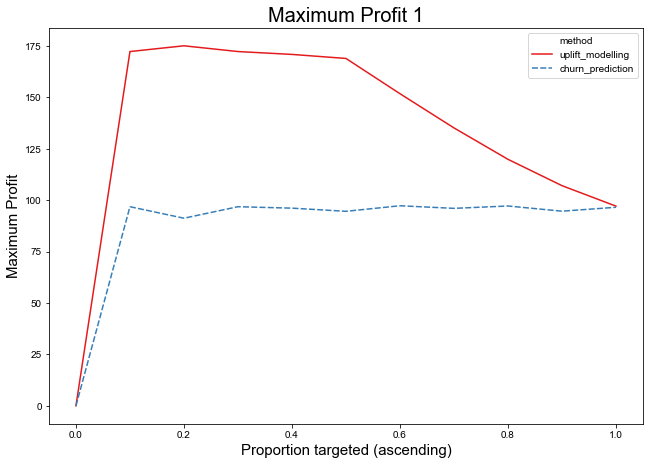

In [27]:
sns.lineplot(x='n', y='mp', hue='method', data=result_mp1, style="method", palette='Set1')
sns.set_style("whitegrid")
plt.title('Maximum Profit 1',fontsize=20)
plt.xlabel('Proportion targeted (ascending)',fontsize=15)
plt.ylabel('Maximum Profit',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

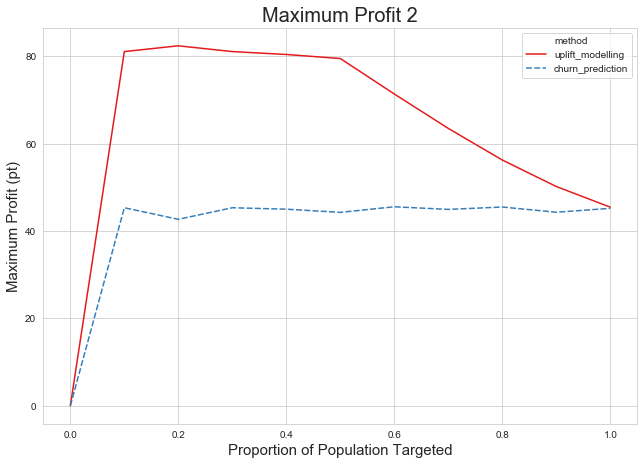

In [28]:
sns.lineplot(x='n', y='mp', hue='method', data=result_mp2, style="method", palette='Set1')
sns.set_style("whitegrid")
plt.title('Maximum Profit 2',fontsize=20)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.ylabel('Maximum Profit (pt)',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

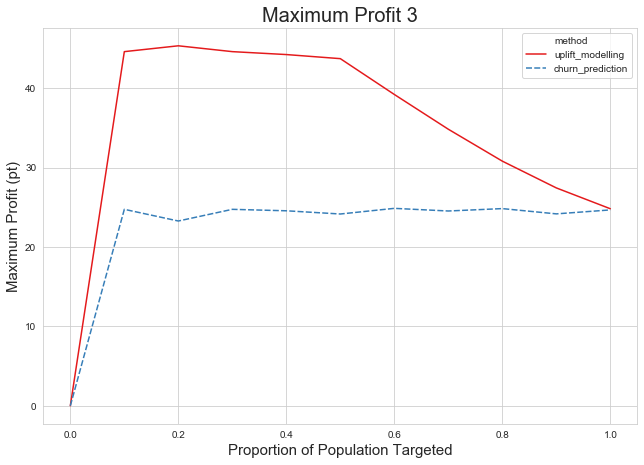

In [29]:
sns.lineplot(x='n', y='mp', hue='method', data=result_mp3, style="method", palette='Set1')
sns.set_style("whitegrid")
plt.title('Maximum Profit 3',fontsize=20)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.ylabel('Maximum Profit (pt)',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

<h2>Treatment and Control

In [30]:
df_data_uplift_all

,index,target_class,Stay,coach,p_target,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score
0,134,0,0,0,0,0.986596,0.000519,0.000242,0.012643,1.961368
1,182,0,0,0,0,0.986596,0.000519,0.000242,0.012643,1.961368
2,181,0,0,0,0,0.980347,0.001554,0.000450,0.017649,1.947138
3,133,0,0,0,0,0.980347,0.001554,0.000450,0.017649,1.947138
4,72,3,1,1,3,0.003449,0.000083,0.005917,0.990552,1.941274
...,...,...,...,...,...,...,...,...,...,...
992,609,2,0,1,2,0.000618,0.008007,0.988712,0.002663,-1.851385
993,887,2,0,1,2,0.000097,0.002091,0.980385,0.017427,-1.876384
994,755,1,1,0,1,0.000190,0.965985,0.031771,0.002054,-1.878150
995,272,2,0,1,2,0.001973,0.041679,0.942115,0.014233,-1.879827


In [32]:
#prepare 3 dataframe for CPMPU
CPMPU1 = pd.DataFrame({"n":[], 
                      "QINI":[], 
                      "TR":[],  
                      "mpu":[]})
CPMPU2, CPMPU3, CUMPU1, CUMPU2, CUMPU3=CPMPU1.copy(), CPMPU1.copy(), CPMPU1.copy(), CPMPU1.copy(), CPMPU1.copy()
CP_list1, CP_list2, CP_list3, CU_list1, CU_list2, CU_list3=[], [], [], [], [], []
#prepare QU & QC dataframe
QU = pd.DataFrame({"n":[],  
                    "uplift":[]})
QC = QU.copy()
k = round(len(df_data_churn_all)/10)
QU_list, QC_list = [],[]
p4_1=(b1-c)
p4_2=(b2-c)
p4_3=(b3-c)


for i in range(10):
    m=(i+1)*k 
        
    #Qini Churn Variables
    RC_churn=sum((df_data_churn_all.Stay[0:m]==1)&(df_data_churn_all.coach[0:m]==0))
    RT_churn=sum((df_data_churn_all.Stay[0:m]==1)&(df_data_churn_all.coach[0:m]==1))
    NC_churn=sum(df_data_churn_all.coach[0:m]==0)
    NT_churn=sum(df_data_churn_all.coach[0:m]==1)
    QINI_c = RT_churn-((RC_churn*NT_churn)/NC_churn)
    QINI_churn = QINI_c
    if i>=1:
        QINI_churn = QINI_c/(i+1)
    QC_list.append(pd.Series([((i+1)/10), QINI_churn], index=QC.columns))
    
    #Qini Uplift Variables
    RC=sum((df_data_uplift_all.Stay[0:m]==1)&(df_data_uplift_all.coach[0:m]==0))
    RT=sum((df_data_uplift_all.Stay[0:m]==1)&(df_data_uplift_all.coach[0:m]==1))
    NC=sum(df_data_uplift_all.coach[0:m]==0)
    NT=sum(df_data_uplift_all.coach[0:m]==1)
    QINI_u = RT-((RC*NT)/NC)
    QINI_uplift = QINI_u
    if i>=1:
        QINI_uplift = QINI_u/(i+1)
    QU_list.append(pd.Series([((i+1)/10), QINI_uplift], index=QU.columns))
    
    
    #TR
    TR_churn=sum(df_data_churn_all.target_class[0:m] == 3)
    TR_uplift=sum(df_data_uplift_all.target_class[0:m] == 3)
    CPMPU1
    #Churn Prediction mpu 
    #Qini & TR for churn prediction
    u_profit1=(QINI_c*p4_1)
    tr_profit1=(TR_churn*i1)
    u_profit2=(QINI_c*p4_2)
    tr_profit2=(TR_churn*i2)
    u_profit3=(QINI_c*p4_3)
    tr_profit3=(TR_churn*i3)
    
    #churn Maximum Profit Uplift
    mpu1=(u_profit1 - tr_profit1)/m
    mpu2=(u_profit2 - tr_profit2)/m
    mpu3=(u_profit3 - tr_profit3)/m
    
    #Qini & TR for uplift prediction
    u_u_profit1=(QINI_u*p4_1)
    u_tr_profit1=(TR_uplift*i1)
    u_u_profit2=(QINI_u*p4_2)
    u_tr_profit2=(TR_uplift*i2)
    u_u_profit3=(QINI_u*p4_3)
    u_tr_profit3=(TR_uplift*i3)
    
    #Churn Uplift Maximum Profit Uplift
    u_mpu1=(u_u_profit1 - u_tr_profit1)/m
    u_mpu2=(u_u_profit2 - u_tr_profit2)/m
    u_mpu3=(u_u_profit3 - u_tr_profit3)/m
    
    #cumulative mpu per customer
#     if i >= 1:
#         mpu1 = mpu1/(i+1)
#         mpu2 = mpu2/(i+1)
#         mpu3 = mpu3/(i+1)
        
#         u_mpu1 = u_mpu1/(i+1)
#         u_mpu2 = u_mpu2/(i+1)
#         u_mpu3 = u_mpu3/(i+1)
    
    CP_list1.append(pd.Series([((i+1)/10), QINI_c, TR_churn, mpu1], index=CPMPU1.columns))
    CP_list2.append(pd.Series([((i+1)/10), QINI_c, TR_churn, mpu2], index=CPMPU2.columns))    
    CP_list3.append(pd.Series([((i+1)/10), QINI_c, TR_churn, mpu3], index=CPMPU3.columns))    
        
    CU_list1.append(pd.Series([((i+1)/10), QINI_u, TR_uplift, u_mpu1], index=CUMPU1.columns))
    CU_list2.append(pd.Series([((i+1)/10), QINI_u, TR_uplift, u_mpu2], index=CUMPU2.columns))    
    CU_list3.append(pd.Series([((i+1)/10), QINI_u, TR_uplift, u_mpu3], index=CUMPU3.columns)) 
    
    
# append list into dataframe    
QU = QU.append(QU_list , ignore_index=True)
QC = QC.append(QC_list , ignore_index=True)
# add q0 into dataframe
q0 = pd.DataFrame({'n':0, 'uplift':0}, index =[0])
QU = pd.concat([q0, QU]).reset_index(drop = True)
QC = pd.concat([q0, QC]).reset_index(drop = True)

# add q0 into dataframe
q0 = pd.DataFrame({'n':0, 'mpu':0}, index =[0])
# append list into dataframe    
CPMPU1 = CPMPU1.append(CP_list1 , ignore_index=True)
CPMPU2 = CPMPU2.append(CP_list2 , ignore_index=True)
CPMPU3 = CPMPU3.append(CP_list3 , ignore_index=True)

CUMPU1 = CUMPU1.append(CU_list1 , ignore_index=True)
CUMPU2 = CUMPU2.append(CU_list2 , ignore_index=True)
CUMPU3 = CUMPU3.append(CU_list3 , ignore_index=True)

# add q0 into dataframe
CPMPU1 = pd.concat([q0, CPMPU1]).reset_index(drop = True)
CPMPU2 = pd.concat([q0, CPMPU2]).reset_index(drop = True)
CPMPU3 = pd.concat([q0, CPMPU3]).reset_index(drop = True)

CUMPU1 = pd.concat([q0, CUMPU1]).reset_index(drop = True)
CUMPU2 = pd.concat([q0, CUMPU2]).reset_index(drop = True)
CUMPU3 = pd.concat([q0, CUMPU3]).reset_index(drop = True)

In [33]:
CUMPU1

,n,mpu,QINI,TR
0,0.0,0.000000,NaN,NaN
1,0.1,93.857273,49.727273,51.0
2,0.2,107.102945,113.520548,117.0
3,0.3,105.899231,168.692308,180.0
4,0.4,101.681111,216.444444,240.0
5,0.5,97.700048,260.452381,298.0
6,0.6,75.081263,242.757576,326.0
7,0.7,51.404783,197.956522,341.0
8,0.8,30.334229,139.233083,344.0
9,0.9,15.530533,87.726027,348.0


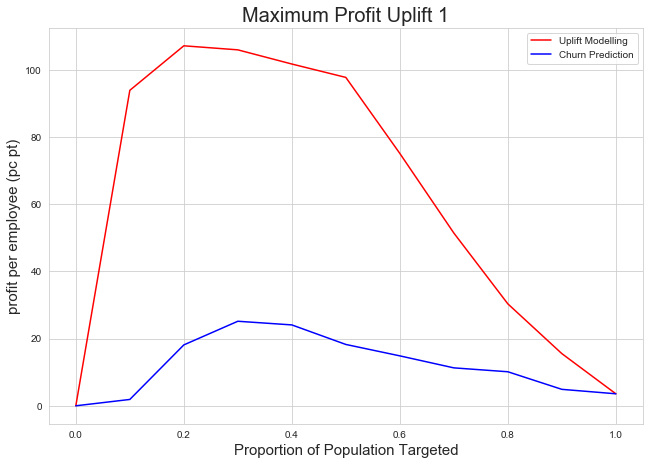

In [34]:
sns.lineplot(x=CUMPU1.n, y=CUMPU1.mpu, label='Uplift Modelling', color='red')
sns.lineplot(x=CPMPU1.n, y=CPMPU1.mpu, label='Churn Prediction', color='blue')

sns.set_style("whitegrid")
plt.title('Maximum Profit Uplift 1',fontsize=20)
plt.ylabel('profit per employee (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

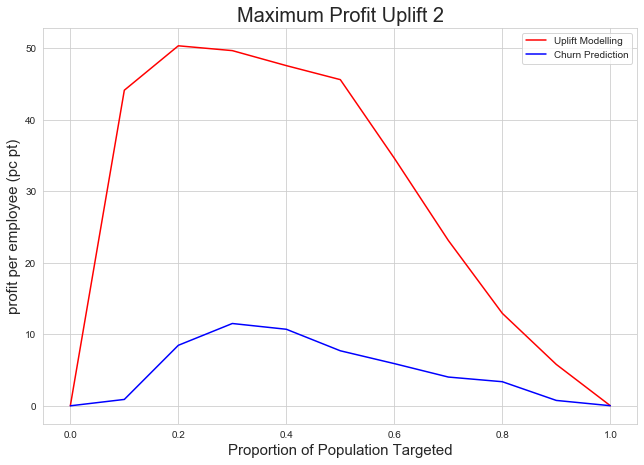

In [35]:
sns.lineplot(x=CUMPU2.n, y=CUMPU2.mpu, label='Uplift Modelling', color='red')
sns.lineplot(x=CPMPU2.n, y=CPMPU2.mpu, label='Churn Prediction', color='blue')

sns.set_style("whitegrid")
plt.title('Maximum Profit Uplift 2',fontsize=20)
plt.ylabel('profit per employee (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

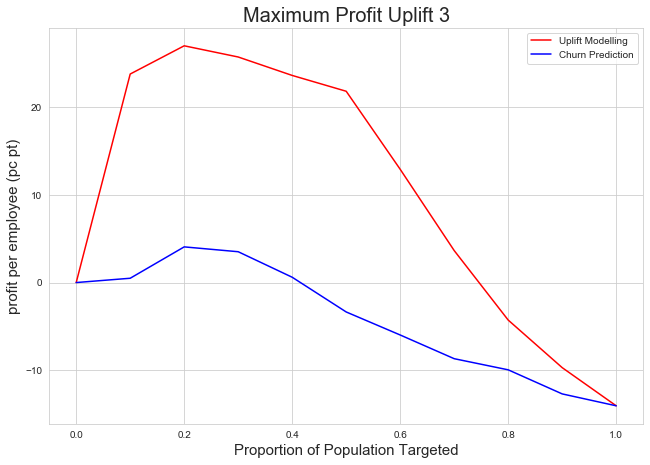

In [36]:
sns.lineplot(x=CUMPU3.n, y=CUMPU3.mpu, label='Uplift Modelling', color='red')
sns.lineplot(x=CPMPU3.n, y=CPMPU3.mpu, label='Churn Prediction', color='blue')

sns.set_style("whitegrid")
plt.title('Maximum Profit Uplift 3',fontsize=20)
plt.ylabel('profit per employee (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

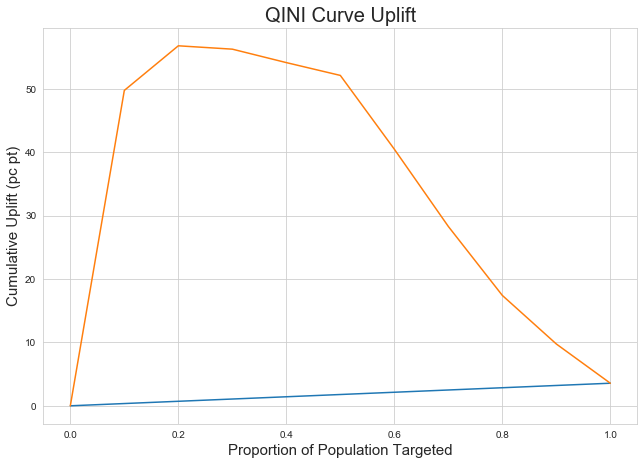

In [37]:
random = np.linspace(QU['uplift'][0],QU['uplift'][10],11)
sns.lineplot(x=QU.n, y=random)
sns.lineplot(x=QU.n, y=QU.uplift)

sns.set_style("whitegrid")
plt.title('QINI Curve Uplift',fontsize=20)
plt.ylabel('Cumulative Uplift (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

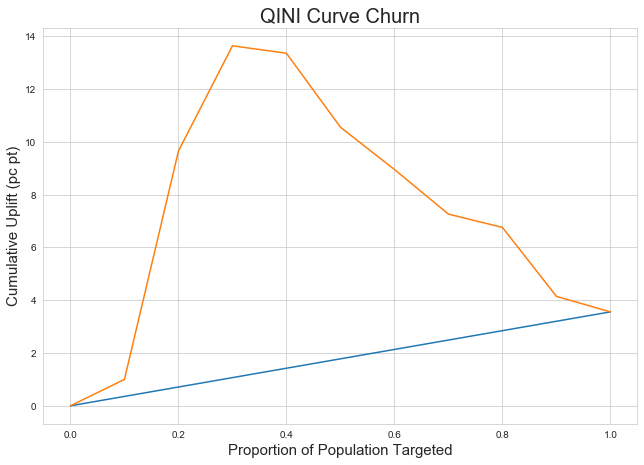

In [38]:
random = np.linspace(QC['uplift'][0],QC['uplift'][10],11)
sns.lineplot(x=QC.n, y=random)
sns.lineplot(x=QC.n, y=QC.uplift)
sns.set_style("whitegrid")
plt.title('QINI Curve Churn',fontsize=20)
plt.ylabel('Cumulative Uplift (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

<h2>Pylift

In [40]:
df_data_pylift = df_model.copy()
df_data_pylift.drop(['target_class'], axis=1)
df_data_pylift

,Stay,age,coach,extraversion,independ,selfcontrol,anxiety,novator,stag_cluster,gender_f,...,head_gender_f,head_gender_m,greywage_grey,greywage_white,way_bus,way_car,way_foot,target_class,p_target,p_stay
0,1,35.0,1,6.2,4.1,5.7,7.1,8.3,0,0,...,1,0,0,1,1,0,0,3,3,1
1,1,35.0,1,6.2,6.2,2.6,4.8,8.3,0,1,...,0,1,0,1,1,0,0,3,3,1
2,1,35.0,1,5.4,7.6,4.9,2.5,6.7,0,1,...,0,1,0,1,1,0,0,3,3,1
3,1,29.0,1,8.6,6.9,2.6,4.0,7.5,0,1,...,1,0,0,1,1,0,0,3,3,1
4,1,28.0,1,8.6,5.5,4.9,4.8,5.2,0,1,...,0,1,0,1,0,1,0,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,1,22.0,1,7.0,4.8,4.9,6.3,7.5,3,1,...,0,1,0,1,1,0,0,3,3,1
993,0,33.0,0,4.6,3.4,6.4,6.3,6.7,3,1,...,0,1,0,1,0,0,1,0,0,0
994,0,34.0,1,3.8,5.5,6.4,4.0,4.4,3,0,...,0,1,0,1,1,0,0,2,2,0
995,1,24.0,1,3.8,6.2,8.0,4.0,2.9,3,0,...,0,1,0,1,1,0,0,3,3,1


pylift modelling

In [41]:
up = TransformedOutcome(df_model, col_treatment=treat, col_outcome='Stay')

In [42]:
up.randomized_search(n_iter=20, n_jobs=10, random_state=46)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   36.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  1.4min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None...
                                                      16, 17, 18, 19, 20],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
 

In [43]:
up.fit(**up.rand_search_.best_params_)

No handles with labels found to put in legend.


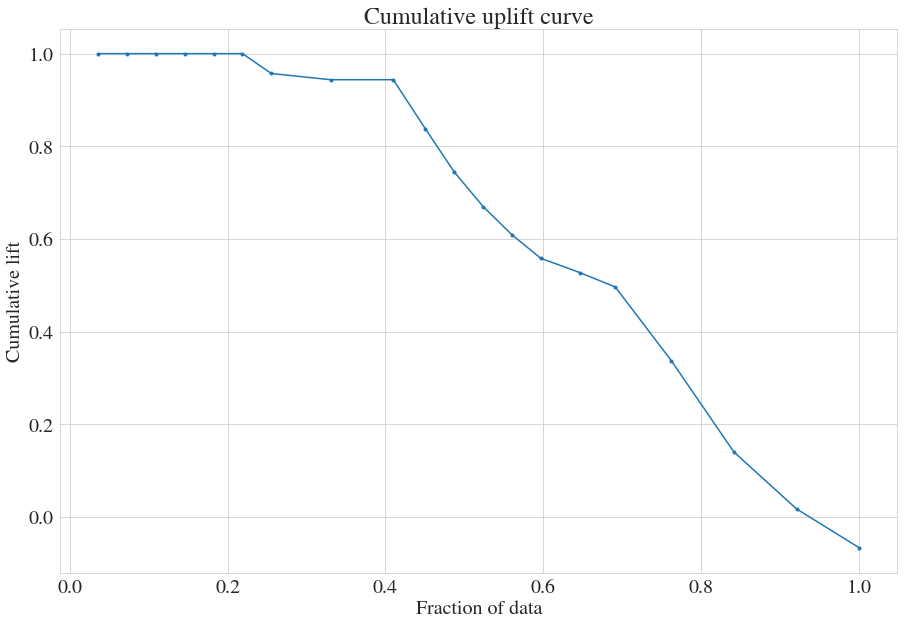

In [44]:
up.plot(plot_type='cuplift')

In [45]:
up.test_results_.q1_cgains

0.6746505509586823

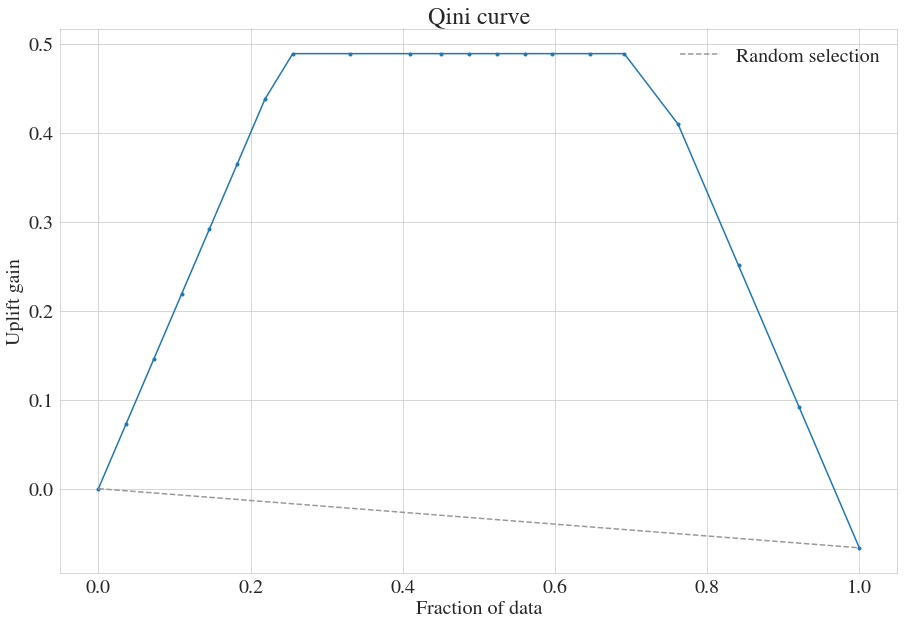

In [46]:
up.plot(plot_type='qini')

Seed 0 finished.
Seed 1 finished.
Seed 2 finished.
Seed 3 finished.


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Seed 4 finished.


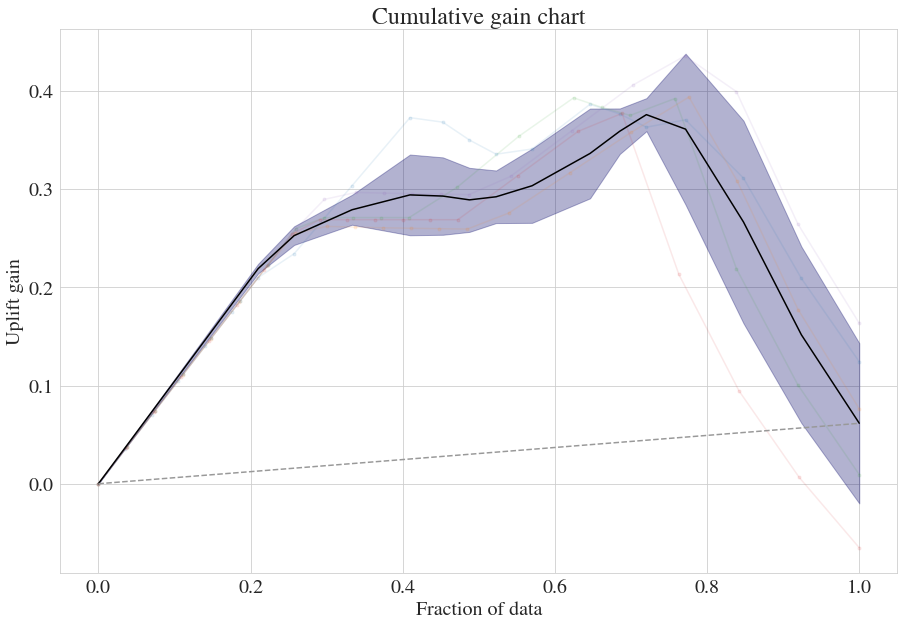

In [47]:
up.shuffle_fit(params=up.rand_search_.best_params_, nthread=30, iterations=5);
up.plot(show_shuffle_fits=True)

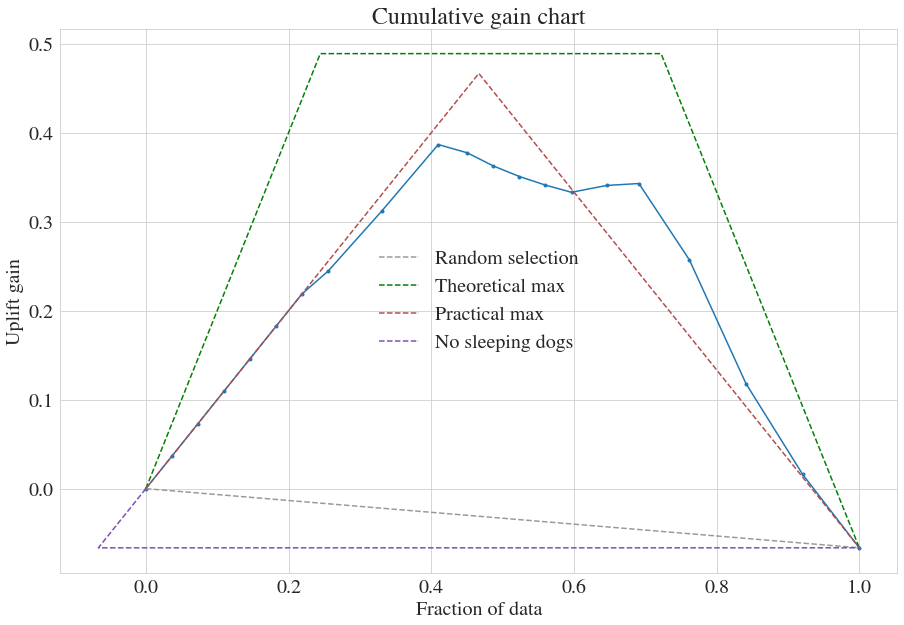

In [48]:
up.plot(show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)

<h1>Causal Lift

In [49]:
def calc_cumulative_gains(df: pd.DataFrame, actual_col: str, predicted_col:str, probability_col:str):
    df.sort_values(by=probability_col, ascending=False, inplace=True)

    subset = df[df[predicted_col] == True]

    rows = []
    for group in np.array_split(subset, 10):
        score = sklearn.metrics.accuracy_score(group[actual_col].tolist(),
                                                   group[predicted_col].tolist(),
                                                   normalize=False)

        rows.append({'NumCases': len(group), 'NumCorrectPredictions': score})

    lift = pd.DataFrame(rows)

    #Cumulative Gains Calculation
    lift['RunningCorrect'] = lift['NumCorrectPredictions'].cumsum()
    lift['PercentCorrect'] = lift.apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x['RunningCorrect'], axis=1)
    lift['CumulativeCorrectBestCase'] = lift['NumCases'].cumsum()
    lift['PercentCorrectBestCase'] = lift['CumulativeCorrectBestCase'].apply(
        lambda x: 100 if (100 / lift['NumCorrectPredictions'].sum()) * x > 100 else (100 / lift[
            'NumCorrectPredictions'].sum()) * x)
    lift['AvgCase'] = lift['NumCorrectPredictions'].sum() / len(lift)
    lift['CumulativeAvgCase'] = lift['AvgCase'].cumsum()
    lift['PercentAvgCase'] = lift['CumulativeAvgCase'].apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x)

    #Lift Chart
    lift['NormalisedPercentAvg'] = 1
    lift['NormalisedPercentWithModel'] = lift['PercentCorrect'] / lift['PercentAvgCase']

    return lift

In [50]:
cum_lift = calc_cumulative_gains(df_data_churn, 'Stay', 'p_stay', 'stay_score')
cum_lift

,NumCases,NumCorrectPredictions,RunningCorrect,PercentCorrect,CumulativeCorrectBestCase,PercentCorrectBestCase,AvgCase,CumulativeAvgCase,PercentAvgCase,NormalisedPercentAvg,NormalisedPercentWithModel
0,36,28,28,8.832808,36,11.356467,31.7,31.7,10.0,1,0.883281
1,36,32,60,18.927445,72,22.712934,31.7,63.4,20.0,1,0.946372
2,36,32,92,29.022082,108,34.069401,31.7,95.1,30.0,1,0.967403
3,36,31,123,38.801262,144,45.425868,31.7,126.8,40.0,1,0.970032
4,36,33,156,49.211356,180,56.782334,31.7,158.5,50.0,1,0.984227
5,36,34,190,59.936909,216,68.138801,31.7,190.2,60.0,1,0.998948
6,36,31,221,69.716088,252,79.495268,31.7,221.9,70.0,1,0.995944
7,35,31,252,79.495268,287,90.536278,31.7,253.6,80.0,1,0.993691
8,35,31,283,89.274448,322,100.000000,31.7,285.3,90.0,1,0.991938
9,35,34,317,100.000000,357,100.000000,31.7,317.0,100.0,1,1.000000


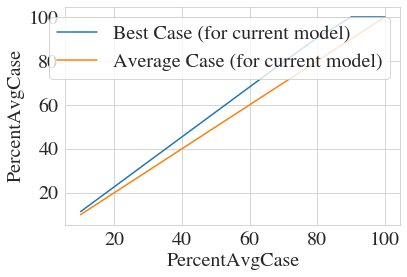

In [51]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_lift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_lift, label="Average Case (for current model)")

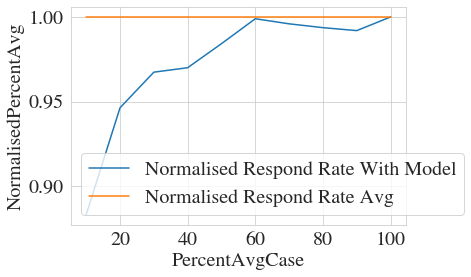

In [52]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_lift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_lift, label="Normalised Respond Rate Avg")

In [53]:
cum_uplift = calc_cumulative_gains(df_data_uplift, 'target_class', 'p_target', 'uplift_score')
cum_uplift

C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in longlong_scalars
C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


,NumCases,NumCorrectPredictions,RunningCorrect,PercentCorrect,CumulativeCorrectBestCase,PercentCorrectBestCase,AvgCase,CumulativeAvgCase,PercentAvgCase,NormalisedPercentAvg,NormalisedPercentWithModel
0,3,0,0,NaN,3,100,0.0,0.0,NaN,1,NaN
1,2,0,0,NaN,5,100,0.0,0.0,NaN,1,NaN
2,2,0,0,NaN,7,100,0.0,0.0,NaN,1,NaN
3,2,0,0,NaN,9,100,0.0,0.0,NaN,1,NaN
4,2,0,0,NaN,11,100,0.0,0.0,NaN,1,NaN
5,2,0,0,NaN,13,100,0.0,0.0,NaN,1,NaN
6,2,0,0,NaN,15,100,0.0,0.0,NaN,1,NaN
7,2,0,0,NaN,17,100,0.0,0.0,NaN,1,NaN
8,2,0,0,NaN,19,100,0.0,0.0,NaN,1,NaN
9,2,0,0,NaN,21,100,0.0,0.0,NaN,1,NaN


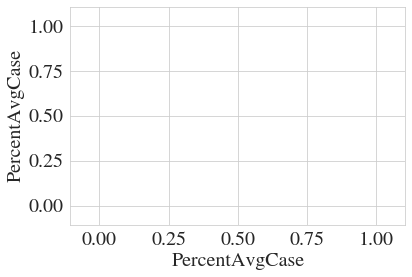

In [54]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_uplift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_uplift, label="Average Case (for current model)")

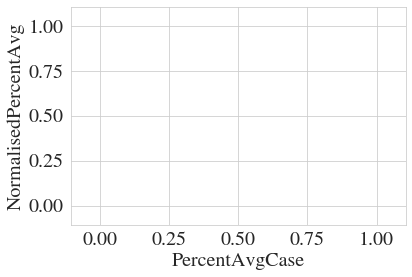

In [55]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_uplift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_uplift, label="Normalised Respond Rate Avg")

In [56]:
#create feature set and labels
df_model_causal = df_model.drop(['target_class','p_stay','p_target'],axis=1)
df_model_causal.rename(columns={treat:'Treatment','Stay':'Outcome'}, inplace=True)
df_model_causal

,Outcome,age,Treatment,extraversion,independ,selfcontrol,anxiety,novator,stag_cluster,gender_f,...,traffic_referal,traffic_youjs,head_gender_f,head_gender_m,greywage_grey,greywage_white,way_bus,way_car,way_foot,TransformedOutcome
0,1,35.0,1,6.2,4.1,5.7,7.1,8.3,0,0,...,0,0,1,0,0,1,1,0,0,1.45974
1,1,35.0,1,6.2,6.2,2.6,4.8,8.3,0,1,...,0,0,0,1,0,1,1,0,0,1.45974
2,1,35.0,1,5.4,7.6,4.9,2.5,6.7,0,1,...,0,0,0,1,0,1,1,0,0,1.45974
3,1,29.0,1,8.6,6.9,2.6,4.0,7.5,0,1,...,0,0,1,0,0,1,1,0,0,1.45974
4,1,28.0,1,8.6,5.5,4.9,4.8,5.2,0,1,...,0,1,0,1,0,1,0,1,0,1.45974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,1,22.0,1,7.0,4.8,4.9,6.3,7.5,3,1,...,0,0,0,1,0,1,1,0,0,1.45974
993,0,33.0,0,4.6,3.4,6.4,6.3,6.7,3,1,...,0,0,0,1,0,1,0,0,1,-0
994,0,34.0,1,3.8,5.5,6.4,4.0,4.4,3,0,...,1,0,0,1,0,1,1,0,0,0
995,1,24.0,1,3.8,6.2,8.0,4.0,2.9,3,0,...,1,0,0,1,0,1,1,0,0,1.45974


In [57]:
#splitting train and test groups
train_df, test_df = train_test_split(df_model_causal, test_size=0.2, random_state=42, stratify=df_model_causal['Treatment'])

In [58]:
""" Step 0. Import CausalLift
"""

from causallift import CausalLift

""" Step 1. Feed datasets and optionally compute estimated propensity scores
using logistic regression if set enable_ipw = True.
"""


cl = CausalLift(train_df, test_df, enable_ipw=True, verbose=3)

""" Step 2. Train 2 classification models (XGBoost) for treated and untreated
samples independently and compute estimated CATE (Conditional Average Treatment
Effect), ITE (Individual Treatment Effect), or uplift score.
"""

train_df, test_df = cl.estimate_cate_by_2_models()

""" Step 3. Estimate how much conversion rate will increase by selecting treatment
(campaign) targets as recommended by the uplift modeling.
"""

estimated_effect_df = cl.estimate_recommendation_impact()

ModuleNotFoundError: No module named 'causallift'

In [ ]:
estimated_effect_df